In [2]:

import random

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential
from keras.layers import Conv2D, Flatten, Dropout, MaxPool2D
from keras.optimizers import Adam

from keras.datasets import  fashion_mnist


(6000, 28, 28)

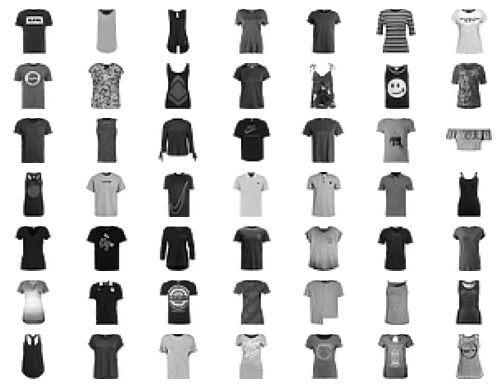

In [5]:
def cargar_imagenes():
    (Xtrain, Ytrain), (_, _) = fashion_mnist.load_data()

    # Nos quedamos con las camiseta
    indice = np.where(Ytrain == 0)
    indice = indice[0]
    Xtrain = Xtrain[indice, :,:]
    # Normalizamos los datos
    X = Xtrain.astype('float32') / 255.0
    return X

dataset = cargar_imagenes()

for i in range(49):
  plt.subplot(7, 7, 1 + i)
  plt.axis('off')
  plt.imshow(dataset[i], cmap="binary")

dataset.shape

In [29]:
print("Discriminador:")
discriminador = Sequential()
discriminador.add(Conv2D(8, kernel_size=3, padding="same", input_shape = (28,28,1), activation="relu"))
discriminador.add(MaxPool2D())

discriminador.add(Conv2D(32, kernel_size=3, padding="same", activation="relu"))
discriminador.add(MaxPool2D())

discriminador.add(Conv2D(64, kernel_size=3, padding="same", activation="relu"))
discriminador.add(MaxPool2D())

discriminador.add(Flatten())

discriminador.add(Dense(32, activation="relu"))


discriminador.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=0.01)
discriminador.compile(loss="binary_crossentropy", optimizer = optimizer, metrics=["accuracy"])
discriminador.summary()

print("Generador:")
generador = Sequential()
generador.add(Dense(32, input_shape=(1,), activation="relu"))
generador.add(Dense(576, activation="relu"))
generador.add(Reshape((3,3,64)))
generador.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding="valid", activation="relu"))
generador.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu"))
generador.add(Conv2DTranspose(8, kernel_size=3, strides=2, padding="same", activation="relu"))
generador.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding="same", activation="sigmoid"))

generador.summary()

print("Gan:")
gan = Sequential()
gan.add(generador)
gan.add(discriminador)
opt = Adam(learning_rate=0.01)
gan.compile(loss="binary_crossentropy", optimizer = opt, metrics=["accuracy"])
gan.summary()


Discriminador:
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 14, 14, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 14, 14, 32)        2336      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 3,

In [20]:
def get_datos_reales(nmuestras):
  max_len = dataset.shape[0]
  ix = np.random.randint(0, max_len, nmuestras)
  X = dataset[ix]
  y = np.ones((nmuestras, 1))
  return X,y

def get_datos_fake(nmuestras):
  input = np.random.randn(nmuestras)
  X = generador.predict(input)
  y = np.zeros((nmuestras,1))
  return X,y




In [27]:
def entrenamiento(epochs=1, batch_size=128):
  max_len = dataset.shape[0]
  nbatchs = int(max_len / batch_size)

  for epoch in range(epochs):
    print("Epoch : ", epoch)
    for batch in range(nbatchs):
      # entrenar discriminador
      discriminador.trainable = True
      X_real, y_real = get_datos_reales(batch_size//2)
      loss_real, acc_real = discriminador.train_on_batch(X_real, y_real)
      X_fake, y_fake = get_datos_fake(batch_size//2)
      loss_fake, acc_fake = discriminador.train_on_batch(X_fake, y_fake)
      discriminador.trainable = False
      # entrenar generador (a través de la gan completa)
      X_gan = np.random.randn(batch_size).reshape(batch_size, 1)
      y_gan = np.ones((batch_size, 1))
      loss_gan, acc_gan = gan.train_on_batch(X_gan, y_gan)

      print(f"Epoch: {epoch} - batch: {batch}")
      print(f"loss_real: {loss_real} loss_fake: {loss_fake} loss_gan: {loss_gan}")
      print(f"acc_real: {acc_real} acc_fake: {acc_fake} acc_gan: {acc_gan}")



In [ ]:
entrenamiento()

2/2 [==============================] - 0s 11ms/step


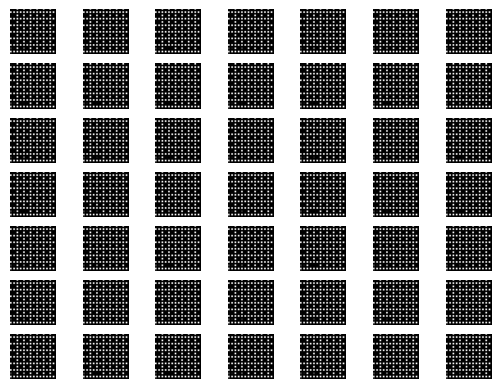

In [33]:
X_pru = np.random.randn(49)
generadas = generador.predict(X_pru)
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(generadas[i], cmap="binary")
plt.show()